# TorchVision SSD Finetuning Tutorial

Based on [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

## Defining your model

In [1]:
from torchvision.models.detection.ssd import ssd300_vgg16


model = ssd300_vgg16(pretrained=True)

## Training and evaluation functions

In [2]:
import lib.detection.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [3]:
from lib.penn_fundan import PennFudanDataset

dataset_train = PennFudanDataset('data/PennFudanPed/', get_transform(train=True))
dataset_val = PennFudanDataset('data/PennFudanPed/', get_transform(train=False))

In [4]:
from torch.utils.data import DataLoader
from lib.detection.utils import collate_fn


# define training and validation data loaders
data_loader_train = DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=12,
    collate_fn=collate_fn
)

data_loader_val = DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=12,
    collate_fn=collate_fn
)

In [5]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.optim import SGD


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and product
num_classes = 2

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = StepLR(optimizer,
                      step_size=3,
                      gamma=0.1)

In [6]:
import tensorboard

%load_ext tensorboard
%tensorboard --logdir runs

In [7]:
from lib.detection.engine import train_one_epoch, evaluate
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

num_epochs = 10

writer = SummaryWriter()

for epoch in tqdm(range(num_epochs), desc='Epoch'):
    train_one_epoch(model, optimizer, data_loader_train,
                    device, epoch, writer=writer)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_val, device, epoch, writer=writer)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

/home/fdf/clones/maibi_cv/.venv/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.833
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.768
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.721
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.974
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Train batch:   0%|          | 0/170 [00:00<?, ?it/s]

creating index...
index created!


Eval batch:   0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.974
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [8]:
# pick one image from the test set
img, _ = dataset_val[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [9]:
prediction

[{'boxes': tensor([[155.4635, 175.6898, 306.0448, 420.7332],
          [424.3633, 169.2684, 530.9561, 481.9518],
          [459.0931, 182.6597, 479.7110, 213.9922],
          [430.0970, 174.5712, 500.0946, 244.2621],
          [443.5312, 170.1072, 466.1533, 198.6870],
          [445.2461, 188.0367, 464.8113, 211.9872],
          [458.9331, 166.9916, 478.8348, 201.4185]], device='cuda:0'),
  'scores': tensor([1.0000, 0.9700, 0.0128, 0.0125, 0.0108, 0.0106, 0.0105],
         device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0')}]

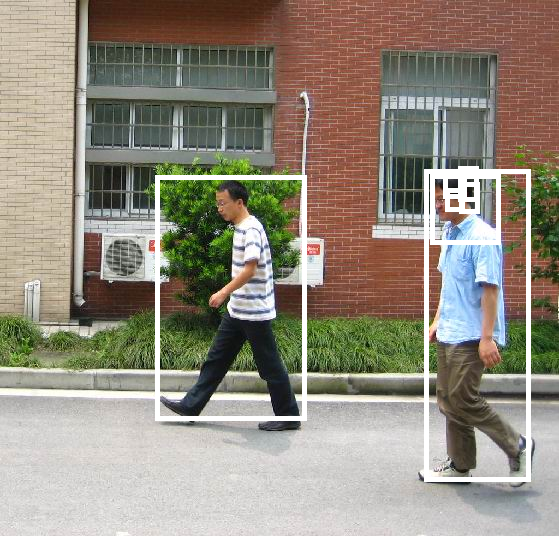

In [10]:
from PIL import Image, ImageDraw

im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(im)

for box in prediction[0]['boxes'].cpu().numpy():
    draw.rectangle(box, width=5)

im